In [1]:
from tamkin import *
from molmod import *

import matplotlib.pyplot as plt
import numpy as np
np.bool = bool
import re
import pandas as pd

import os 
from datetime import date

#sys.path.insert(0, '../code/')
from tamkintools_multi_fidelity_bayesian.tamkin_multi_fidelity import *

### tetrahydrofuran example utilizing Multi-Fidelity models

- The data are read in, normalized and a multi fidelity model is derived based on the weights. In addition, the periodicity of Rotor Experiments is exploited.
- Afterwards the multi fidelity model can be initialized. This includes the selection of the kernel. There is potential for optimization here. The default RBF kernel oscillates relatively strongly (especially when noise in training data is fixed to small numbers). Therefore in physical applications often Matern kernels are used, since these have smoother samples. Especially when derivatives of functions are to be determined.
- after initialization hyperparameters can be fixed 
- then the model is trained
- after training the high fidelity output is used to overwrite the initial data in the tamkin object
- tamkintools is used with the new data, weights are not necessary anymore




In [2]:
#############
# Constants #
#############
R = 8.3144598
R_a = 8.3144598
kcal = 4.1868 # kJ

data_a = pd.read_csv("scan_data/first_a.csv",names=["deg","E"]).sort_values('deg')
data_b = pd.read_csv("scan_data/second_b.csv",names=["deg","E"]).sort_values('deg')
data_c = pd.read_csv("scan_data/third_c.csv",names=["deg","E"]).sort_values('deg')


data_a['fidelity'] = 0.5
data_b['fidelity'] = 0.5
data_c['fidelity'] = 1

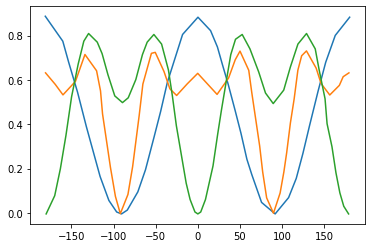

In [3]:
# plot scan data with weights
plt.plot( data_a["deg"],data_a["E"],"-")
plt.plot( data_b["deg"],data_b["E"],"-")
plt.plot( data_c["deg"],data_c["E"],"-")

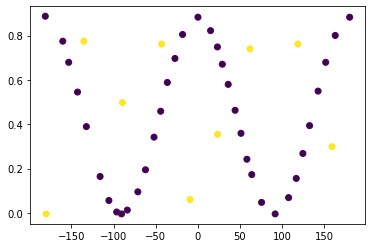

In [4]:
nn=6

a_a = data_a[['deg', 'fidelity']].to_numpy()
a_b = data_b[['deg', 'fidelity']].to_numpy()
a_c = data_c[['deg', 'fidelity']].to_numpy()[::nn,:]

b_a = data_a['E'].to_numpy()
b_b = data_b['E'].to_numpy()
b_c = data_c['E'].to_numpy()[::nn]

a = np.concatenate((a_a, a_c), axis=0)
b = np.concatenate((b_a, b_c), axis=0)

plt.scatter( a[:,0],b,c=a[:,1])

# Multi-Fidelity

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
angle range: 361.15146000496316
set angle range 360


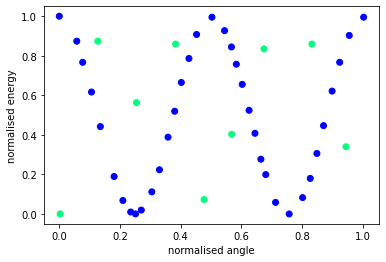

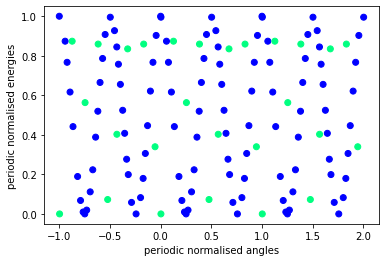

(135, 2)
(135, 1)
Optimization restart 1/5, f = -179.1532682041588
Optimization restart 2/5, f = -179.15328378797292
Optimization restart 3/5, f = -179.153283787413
Optimization restart 4/5, f = -179.1532837881614
Optimization restart 5/5, f = -179.15328378822235


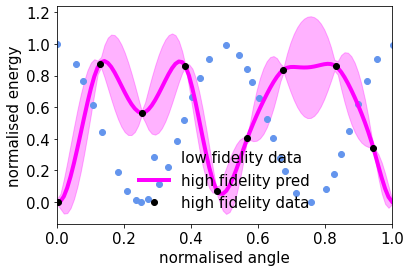

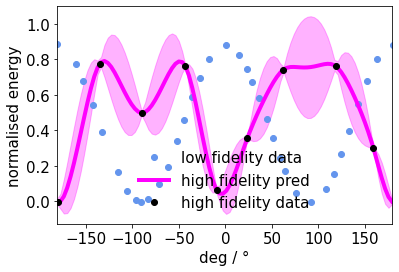

gp.,value,constraints,priors
multifidelity.Mat32.variance,1.166140412563935,+ve,
multifidelity.Mat32.lengthscale,0.5529594465188764,+ve,
multifidelity.Mat32_1.variance,0.38138859435492806,+ve,
multifidelity.Mat32_1.lengthscale,0.12156228139396585,+ve,
multifidelity.scale,0.05386537033663082,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [5]:


# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( a[:,0], b, a[:,1], angle_range=360)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity")
tmf.plot_results("multi_fidelity",ylabel="normalised energy")


# predict values for initial datapoints
normed_angles = np.sort(tmf.normed_angles)
mf_angles, mf_energy, mf_std = tmf.predict_hf(normed_angles)

tmf.lin_mf_model.gpy_model


In [6]:
p = np.squeeze( np.where( tmf.periodic_fidelities == np.max(tmf.periodic_fidelities) ) )

ag = tmf.periodic_angles[p]
bg = tmf.periodic_energies[p]

kernel = GPy.kern.Matern32(1)
high_gp_model = GPy.models.GPRegression( np.atleast_2d( ag ).T, np.atleast_2d( bg ).T , kernel)
high_gp_model.Gaussian_noise.fix(0.0000001)

high_gp_model.optimize_restarts(5)

high_gp_model

Optimization restart 1/5, f = 20.216981650944987
Optimization restart 2/5, f = 20.216981650944973
Optimization restart 3/5, f = 20.216981650946238
Optimization restart 4/5, f = 20.21698165094576
Optimization restart 5/5, f = 20.216981650944945


GP_regression.,value,constraints,priors
Mat32.variance,0.3943991379496587,+ve,
Mat32.lengthscale,0.12635591906806343,+ve,
Gaussian_noise.variance,1e-07,+ve fixed,


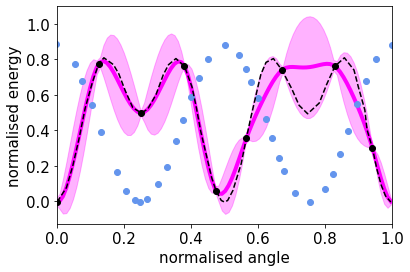

In [14]:
save = "multi_fidelity_plus"

dummy = np.linspace(0,1,100)
ndummy, hf_mean, hf_std = tmf.predict_hf(dummy)


plt.plot(ndummy, hf_mean,color=tmf.colors[-1], label="high fidelity prediction",linewidth=tmf.lsize)
plt.fill_between(ndummy, hf_mean-hf_std, hf_mean+hf_std,alpha=tmf.alpha,color=tmf.colors[-1])

#plt.scatter(self.angles, self.energies,c=self.fidelities, cmap=self.cmap)
for i,w in enumerate( tmf.unique_weights ):
    #print(i,w)
    p = np.squeeze( np.where( tmf.fidelities==i ) )
    plt.plot( tmf.angles[p], tmf.energies[p],".", 
             color=tmf.colors[i], label=tmf.fidelity_labels[i],
            markersize=tmf.msize)

plt.plot(data_c['deg'].to_numpy(),data_c['E'].to_numpy(),"k--", label="high fidelity data")
    
plt.xlim(-180,180)    
plt.xlabel("deg / °",fontsize=tmf.fsize)
plt.xlabel("normalised angle",fontsize=tmf.fsize)
plt.ylabel("normalised energy",fontsize=tmf.fsize)
#plt.xticks(fontsize=tmf.fsize)     
plt.xticks( np.linspace( -180,180,6 )  , np.around(np.linspace( 0, 1,6),2) ,fontsize=tmf.fsize)   
plt.yticks(fontsize=tmf.fsize)     
#plt.legend(fontsize=tmf.fsize,frameon=False,loc='center left', bbox_to_anchor=(1.01, 0.5))
if save:
    plt.savefig(save+".png", bbox_inches='tight')
    plt.savefig(save+".pdf", bbox_inches='tight')
plt.show()
plt.close()        


# GP on high fidelity data

...for comparison

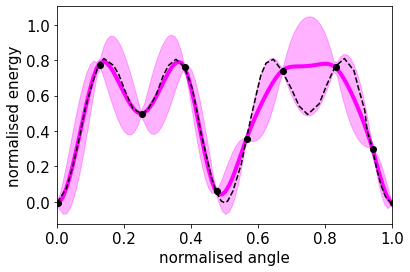

In [15]:
x_plot = np.atleast_2d( np.linspace(0,1,100) ).T
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)
hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)

x_plot = np.squeeze(x_plot)
hf_mean_high_gp_model = np.squeeze(hf_mean_high_gp_model)*tmf.energy_range + tmf.energy_min
hf_std_hf_gp_model = np.squeeze(hf_std_hf_gp_model)*tmf.energy_range



plt.plot(ndummy, hf_mean_high_gp_model,"-",label="gaussian grocess prediction",linewidth=tmf.lsize,color="magenta")
plt.fill_between(ndummy, hf_mean_high_gp_model-hf_std_hf_gp_model, hf_mean_high_gp_model+hf_std_hf_gp_model,
                 alpha=.3,color="magenta")

plt.plot(ag*360-180, bg*tmf.energy_range + tmf.energy_min, ".k",label="high fidelity training data",markersize=tmf.msize)

plt.plot(data_c['deg'].to_numpy(),data_c['E'].to_numpy(),"k--", label="high fidelity data")

plt.xlim( (-180,180) )
plt.xlabel("deg / °",fontsize=tmf.fsize)
plt.xlabel("normalised angle",fontsize=tmf.fsize)
plt.ylabel("normalised energy",fontsize=tmf.fsize)
#plt.xticks(fontsize=tmf.fsize)     
plt.xticks( np.linspace( -180,180,6 )  , np.around(np.linspace( 0, 1,6),2) ,fontsize=tmf.fsize)       
plt.yticks(fontsize=tmf.fsize)     
#plt.legend(fontsize=tmf.fsize,frameon=False,loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.savefig("gp_on_high_fidelity.png", bbox_inches='tight')
plt.savefig("gp_on_high_fidelity.pdf", bbox_inches='tight')